In [52]:
## Table & Visualization Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import pickle
import json

## Prediction Libraries
from sklearn.metrics import classification_report, confusion_matrix, \
accuracy_score, plot_confusion_matrix, auc, roc_curve

## Cross-Validation Libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

## Model Libraries
from xgboost import XGBClassifier

In [53]:
## Change this to your new training data
df = pd.read_csv("df_cleaned.csv")
df = df.drop_duplicates(subset='website')

In [54]:
df.head()

,Unnamed: 0,merchant_name,broken_link_score,link_contact_us_exist,cu_email_exist,cu_phone_number_exist,link_about_us_exist,link_tnc_exist,tnc_refund_policy_exist,contact_us_score,tnc_score,links_response,website,fraud_score,label
0,0,CV.ASIATRIPINDONESIA,0.000000,1.0,1.0,1.0,0.0,1.0,1.0,100.0,100.0,{'https://asiatrip.id/reseller/': '<Response [...,http://asiatrip.id/,0.000000,APPROVED
1,1,Pt.BloomingLotusYoga,70.000000,1.0,1.0,1.0,1.0,1.0,1.0,100.0,100.0,{'http://www.blooming-lotus-yoga.com/bliss-mag...,https://www.blooming-lotus-yoga.com,0.000000,APPROVED
2,2,YayasanGreenSejahtera,11.111111,1.0,1.0,1.0,1.0,1.0,1.0,100.0,100.0,"{'': 'No Response/Timeout', 'https://greenseja...",https://greensejahterafoundation.com/,0.000000,APPROVED
3,3,PTMatairTerraSolusi,12.500000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,"{'': 'No Response/Timeout', 'https://www.matai...",http://www.matair.co.id,0.666667,APPROVED
4,4,SimplyMii,0.000000,1.0,1.0,1.0,0.0,0.0,0.0,100.0,0.0,{'https://www.simplymii.com/products/category/...,https://www.simplymii.com/,0.000000,APPROVED


In [55]:
df.groupby("label").size()

label
APPROVED    215
REJECTED     77
dtype: int64

In [56]:
df.shape

(292, 15)

In [57]:
y = df['label'].apply(lambda x: 1 if x == 'REJECTED' else 0)

In [58]:
X = df.iloc[:, 2:9]

## Train/Test Split

In [59]:
X.head(1)

,broken_link_score,link_contact_us_exist,cu_email_exist,cu_phone_number_exist,link_about_us_exist,link_tnc_exist,tnc_refund_policy_exist
0,0.0,1.0,1.0,1.0,0.0,1.0,1.0


In [60]:
## Binarize broken_link_score, with threshold 50.0
X["broken_link_score"] = (X["broken_link_score"] < 50.0)

In [61]:
for col in X:
    X[col] = X[col].astype(int)

In [62]:
X['broken_link_score']

0      1
1      0
2      1
3      1
4      1
      ..
435    0
436    1
437    0
438    0
440    0
Name: broken_link_score, Length: 292, dtype: int64

In [63]:
X.shape

(292, 7)

In [64]:
X.columns

Index(['broken_link_score', 'link_contact_us_exist', 'cu_email_exist',
       'cu_phone_number_exist', 'link_about_us_exist', 'link_tnc_exist',
       'tnc_refund_policy_exist'],
      dtype='object')

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [66]:
model_choice = XGBClassifier()

In [67]:
clf = model_choice
clf = clf.fit(X_train, y_train)

In [68]:
## Using the best TPR threshold
# y_pred = (clf.predict_proba(X_test)[:,1] >= 0.7367280663362746).astype(bool)

In [69]:
## Using the default threshold == 0.5
y_pred = clf.predict(X_test)

In [70]:
y_pred_proba = clf.predict_proba(X_test)

In [71]:
np.round(accuracy_score(y_test, y_pred), 2)

0.84

In [72]:
y_train.value_counts(), y_test.value_counts()

(0    141
 1     54
 Name: label, dtype: int64,
 0    74
 1    23
 Name: label, dtype: int64)

In [73]:
## Confusion matrix with best TPR threshold
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [74]:
tpr, fpr = np.round((tp/(tp+fn), fp/(fp+tn)), 3)
## TPR = Dari semua REJECTED merchant berapa % yang berhasil kereject, 
## FPR = Dari semua APPROVED berapa % yang kita salah tebak sebagai REJECTED
## This rate applies to a default threshold of 0.5
tpr, fpr

(0.783, 0.149)

In [75]:
tn, fp, fn, tp

(63, 11, 5, 18)

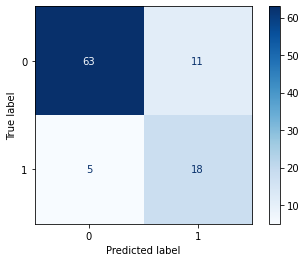

In [76]:
## This matrix visualization is based on 0.5 threshold
plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

In [77]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

In [78]:
auc_score = auc(fpr, tpr)

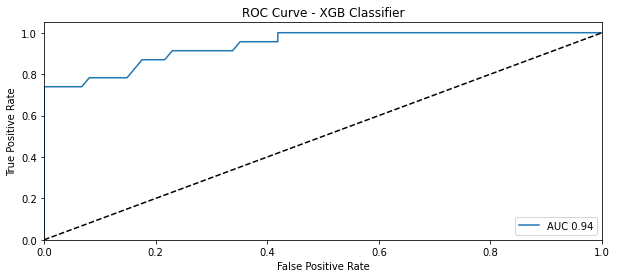

In [79]:
plt.figure(figsize=(10,4))
plt.plot(fpr, tpr, label='AUC %0.2f' % (auc_score))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGB Classifier')
plt.legend(loc="lower right")

# # find optimum thresholds
# i = np.arange(len(tpr)) # index for df
# roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i).apply(lambda x: x), 'thresholds' : pd.Series(thresholds, index = i)})
# df_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

# plt.plot(df_thresh['fpr'], df_thresh['tpr'], marker='o', markersize=8, color='darkred')

# # create the axis of thresholds (scores)
# ax2 = plt.gca().twinx()
# ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='darkred')
# ax2.set_ylabel('Threshold',color='darkred')
# ax2.set_ylim([thresholds[-1],thresholds[0]])
# ax2.set_xlim([fpr[0],fpr[-1]])
# ax2.plot(df_thresh['fpr'], df_thresh['thresholds'], marker='o', markersize=8, color='darkred')


plt.show()
# print(" -- Optimum Threshold -- ")
# print(df_thresh)

In [80]:
print("-- Best TPR Threshold -- ")
## Finding threshold where TPR > Optimum TPR but FPR stays below 15%
for i in range(len(fpr)):
#     if tpr[i] > 0.85 and fpr[i] < 0.20:
        print("TPR %s, FPR %s, Threshold %s" % (tpr[i], fpr[i], thresholds[i]))

-- Best TPR Threshold -- 
TPR 0.0, FPR 0.0, Threshold 1.9945495
TPR 0.7391304347826086, FPR 0.0, Threshold 0.99454945
TPR 0.7391304347826086, FPR 0.02702702702702703, Threshold 0.79009473
TPR 0.7391304347826086, FPR 0.06756756756756757, Threshold 0.6786459
TPR 0.782608695652174, FPR 0.08108108108108109, Threshold 0.64985055
TPR 0.782608695652174, FPR 0.14864864864864866, Threshold 0.5220537
TPR 0.8695652173913043, FPR 0.17567567567567569, Threshold 0.42372957
TPR 0.8695652173913043, FPR 0.20270270270270271, Threshold 0.3942493
TPR 0.8695652173913043, FPR 0.21621621621621623, Threshold 0.38569826
TPR 0.9130434782608695, FPR 0.22972972972972974, Threshold 0.31121477
TPR 0.9130434782608695, FPR 0.2702702702702703, Threshold 0.13905184
TPR 0.9130434782608695, FPR 0.2972972972972973, Threshold 0.13503039
TPR 0.9130434782608695, FPR 0.33783783783783783, Threshold 0.057608888
TPR 0.9565217391304348, FPR 0.35135135135135137, Threshold 0.05580153
TPR 0.9565217391304348, FPR 0.3918918918918919, 

## Bootstrapped

In [81]:
accuracy_list = []
auc_list = []
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=i)
    clf = model_choice
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])
    auc_score = auc(fpr, tpr)
    
    accuracy_list.append(accuracy)
    auc_list.append(auc_score)
    print("Iteration %s: AUC:%s, Accuracy:%s" % (i, auc_score, accuracy))

Iteration 0: AUC:0.961111111111111, Accuracy:0.8865979381443299
Iteration 1: AUC:0.917342799188641, Accuracy:0.7731958762886598
Iteration 2: AUC:0.9142185663924794, Accuracy:0.865979381443299
Iteration 3: AUC:0.9394977168949772, Accuracy:0.8762886597938144
Iteration 4: AUC:0.8667388949079091, Accuracy:0.865979381443299
Iteration 5: AUC:0.9222222222222223, Accuracy:0.8247422680412371
Iteration 6: AUC:0.9365384615384615, Accuracy:0.845360824742268
Iteration 7: AUC:0.8986111111111111, Accuracy:0.8144329896907216
Iteration 8: AUC:0.8647260273972602, Accuracy:0.7835051546391752
Iteration 9: AUC:0.9336075205640423, Accuracy:0.8762886597938144
Iteration 10: AUC:0.9500517598343685, Accuracy:0.845360824742268
Iteration 11: AUC:0.8838742393509127, Accuracy:0.8144329896907216
Iteration 12: AUC:0.9153439153439153, Accuracy:0.8865979381443299
Iteration 13: AUC:0.921957671957672, Accuracy:0.8556701030927835
Iteration 14: AUC:0.9078196347031963, Accuracy:0.8556701030927835
Iteration 15: AUC:0.8951787

Iteration 132: AUC:0.952121212121212, Accuracy:0.8762886597938144
Iteration 133: AUC:0.8827639751552794, Accuracy:0.845360824742268
Iteration 134: AUC:0.9193711967545639, Accuracy:0.8556701030927835
Iteration 135: AUC:0.8764550264550264, Accuracy:0.8247422680412371
Iteration 136: AUC:0.85587899543379, Accuracy:0.8247422680412371
Iteration 137: AUC:0.9503525264394829, Accuracy:0.8247422680412371
Iteration 138: AUC:0.9152777777777777, Accuracy:0.845360824742268
Iteration 139: AUC:0.9354497354497354, Accuracy:0.8556701030927835
Iteration 140: AUC:0.9463636363636363, Accuracy:0.8762886597938144
Iteration 141: AUC:0.8854497354497354, Accuracy:0.7938144329896907
Iteration 142: AUC:0.9665441176470588, Accuracy:0.8969072164948454
Iteration 143: AUC:0.8669444444444444, Accuracy:0.7938144329896907
Iteration 144: AUC:0.8954171562867215, Accuracy:0.8350515463917526
Iteration 145: AUC:0.8859649122807018, Accuracy:0.7835051546391752
Iteration 146: AUC:0.8668864097363083, Accuracy:0.8144329896907216


Iteration 268: AUC:0.950352526439483, Accuracy:0.8556701030927835
Iteration 269: AUC:0.927144535840188, Accuracy:0.8556701030927835
Iteration 270: AUC:0.9277777777777777, Accuracy:0.8969072164948454
Iteration 271: AUC:0.9281524926686218, Accuracy:0.845360824742268
Iteration 272: AUC:0.9417989417989417, Accuracy:0.8762886597938144
Iteration 273: AUC:0.9096969696969697, Accuracy:0.865979381443299
Iteration 274: AUC:0.9497695852534562, Accuracy:0.8762886597938144
Iteration 275: AUC:0.8831453634085213, Accuracy:0.8556701030927835
Iteration 276: AUC:0.9213888888888889, Accuracy:0.8865979381443299
Iteration 277: AUC:0.9130552546045504, Accuracy:0.8865979381443299
Iteration 278: AUC:0.8985507246376812, Accuracy:0.8247422680412371
Iteration 279: AUC:0.9282581453634084, Accuracy:0.845360824742268
Iteration 280: AUC:0.8739858012170386, Accuracy:0.8144329896907216
Iteration 281: AUC:0.9547670639219934, Accuracy:0.845360824742268
Iteration 282: AUC:0.9338624338624338, Accuracy:0.8556701030927835
I

Iteration 392: AUC:0.9139784946236559, Accuracy:0.865979381443299
Iteration 393: AUC:0.9146634615384616, Accuracy:0.865979381443299
Iteration 394: AUC:0.9175228310502284, Accuracy:0.8762886597938144
Iteration 395: AUC:0.8521164021164022, Accuracy:0.845360824742268
Iteration 396: AUC:0.9222643553629468, Accuracy:0.865979381443299
Iteration 397: AUC:0.9070910973084886, Accuracy:0.8556701030927835
Iteration 398: AUC:0.9039393939393939, Accuracy:0.845360824742268
Iteration 399: AUC:0.9433040078201368, Accuracy:0.845360824742268
Iteration 400: AUC:0.88, Accuracy:0.8247422680412371
Iteration 401: AUC:0.878385698808234, Accuracy:0.7731958762886598
Iteration 402: AUC:0.9496969696969697, Accuracy:0.8865979381443299
Iteration 403: AUC:0.8372222222222223, Accuracy:0.8247422680412371
Iteration 404: AUC:0.9069548872180451, Accuracy:0.8350515463917526
Iteration 405: AUC:0.851388888888889, Accuracy:0.7938144329896907
Iteration 406: AUC:0.8502487562189054, Accuracy:0.8041237113402062
Iteration 407: AU

Iteration 523: AUC:0.8955555555555555, Accuracy:0.8556701030927835
Iteration 524: AUC:0.8841277890466531, Accuracy:0.8041237113402062
Iteration 525: AUC:0.930952380952381, Accuracy:0.8350515463917526
Iteration 526: AUC:0.8648582600195504, Accuracy:0.8144329896907216
Iteration 527: AUC:0.9371614301191765, Accuracy:0.8969072164948454
Iteration 528: AUC:0.8942697768762679, Accuracy:0.8556701030927835
Iteration 529: AUC:0.9081168831168831, Accuracy:0.8865979381443299
Iteration 530: AUC:0.9222873900293255, Accuracy:0.865979381443299
Iteration 531: AUC:0.9593939393939394, Accuracy:0.8865979381443299
Iteration 532: AUC:0.8949519230769231, Accuracy:0.8247422680412371
Iteration 533: AUC:0.8512987012987013, Accuracy:0.8350515463917526
Iteration 534: AUC:0.8778439869989166, Accuracy:0.8247422680412371
Iteration 535: AUC:0.9127846790890269, Accuracy:0.8865979381443299
Iteration 536: AUC:0.8580765639589168, Accuracy:0.8144329896907216
Iteration 537: AUC:0.8761415525114156, Accuracy:0.83505154639175

Iteration 654: AUC:0.9427860696517413, Accuracy:0.8556701030927835
Iteration 655: AUC:0.9345063538611924, Accuracy:0.8556701030927835
Iteration 656: AUC:0.8068783068783069, Accuracy:0.8144329896907216
Iteration 657: AUC:0.9161375661375661, Accuracy:0.865979381443299
Iteration 658: AUC:0.948537378114843, Accuracy:0.8969072164948454
Iteration 659: AUC:0.9355362946912242, Accuracy:0.845360824742268
Iteration 660: AUC:0.9420289855072463, Accuracy:0.8865979381443299
Iteration 661: AUC:0.913527397260274, Accuracy:0.865979381443299
Iteration 662: AUC:0.8765212981744422, Accuracy:0.8144329896907216
Iteration 663: AUC:0.9034391534391534, Accuracy:0.8247422680412371
Iteration 664: AUC:0.9497354497354498, Accuracy:0.865979381443299
Iteration 665: AUC:0.8407960199004976, Accuracy:0.7731958762886598
Iteration 666: AUC:0.9177884615384615, Accuracy:0.8144329896907216
Iteration 667: AUC:0.8700828157349896, Accuracy:0.8247422680412371
Iteration 668: AUC:0.9082010582010582, Accuracy:0.845360824742268
It

Iteration 786: AUC:0.9243721461187214, Accuracy:0.865979381443299
Iteration 787: AUC:0.9571092831962398, Accuracy:0.845360824742268
Iteration 788: AUC:0.9216931216931217, Accuracy:0.8762886597938144
Iteration 789: AUC:0.9012121212121212, Accuracy:0.845360824742268
Iteration 790: AUC:0.9165763813651139, Accuracy:0.8556701030927835
Iteration 791: AUC:0.9161057692307691, Accuracy:0.845360824742268
Iteration 792: AUC:0.8896969696969697, Accuracy:0.865979381443299
Iteration 793: AUC:0.8922222222222221, Accuracy:0.8144329896907216
Iteration 794: AUC:0.9314182194616977, Accuracy:0.8556701030927835
Iteration 795: AUC:0.8908333333333333, Accuracy:0.8041237113402062
Iteration 796: AUC:0.8733333333333333, Accuracy:0.8247422680412371
Iteration 797: AUC:0.9248484848484848, Accuracy:0.8247422680412371
Iteration 798: AUC:0.91738894907909, Accuracy:0.8762886597938144
Iteration 799: AUC:0.8982587064676616, Accuracy:0.8350515463917526
Iteration 800: AUC:0.9511111111111112, Accuracy:0.8865979381443299
It

Iteration 911: AUC:0.9337068160597572, Accuracy:0.8762886597938144
Iteration 912: AUC:0.9134328358208956, Accuracy:0.8556701030927835
Iteration 913: AUC:0.9144278606965174, Accuracy:0.8556701030927835
Iteration 914: AUC:0.9189958592132504, Accuracy:0.865979381443299
Iteration 915: AUC:0.8315276273022753, Accuracy:0.7835051546391752
Iteration 916: AUC:0.8836032388663968, Accuracy:0.8247422680412371
Iteration 917: AUC:0.9222222222222222, Accuracy:0.845360824742268
Iteration 918: AUC:0.9152221018418201, Accuracy:0.8144329896907216
Iteration 919: AUC:0.9086111111111111, Accuracy:0.8144329896907216
Iteration 920: AUC:0.8587728194726166, Accuracy:0.8144329896907216
Iteration 921: AUC:0.8741446725317693, Accuracy:0.8144329896907216
Iteration 922: AUC:0.9487878787878788, Accuracy:0.8865979381443299
Iteration 923: AUC:0.924949290060852, Accuracy:0.845360824742268
Iteration 924: AUC:0.9181329423264907, Accuracy:0.8556701030927835
Iteration 925: AUC:0.9402985074626866, Accuracy:0.865979381443299


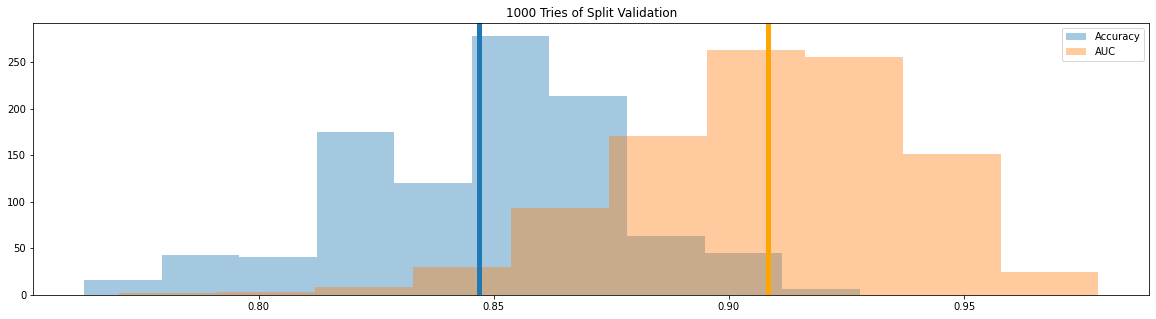

Accuracy mean: 0.85
AUC mean: 0.91


In [82]:
plt.figure(figsize=(20,5))
plt.title("1000 Tries of Split Validation")
sns.distplot(accuracy_list, bins=10, label = 'Accuracy', kde=False)
sns.distplot(auc_list, bins=10, label = 'AUC', kde=False)
plt.axvline(x=pd.Series(accuracy_list).mean(), lw=5)
plt.axvline(x=pd.Series(auc_list).mean(), lw=5, color='orange')
plt.legend()
plt.show()
print("Accuracy mean: %0.2f" % pd.Series(accuracy_list).mean())
print("AUC mean: %0.2f" % pd.Series(auc_list).mean())

## Cross Validation & Hyperparameter Tuning

#### Process

In [83]:
## Hyperparameters
{"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ]}

{'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
 'max_depth': [3, 4, 5, 6, 8, 10, 12, 15],
 'min_child_weight': [1, 3, 5, 7]}

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
model_choice = XGBClassifier(random_state=0)

In [85]:
kfold = StratifiedKFold(n_splits=5)
cv_results = cross_val_score(model_choice, X_train, y_train, cv=kfold, scoring='roc_auc')

In [86]:
cv_results

array([0.89285714, 0.83279221, 0.85064935, 0.89935065, 0.97241379])

In [87]:
## Get the best fold train data to be tested on dataset B
i = 0
idx_train_best = []
idx_test_best = []
for train, test in kfold.split(X_train, y_train):
    if i == np.argmax(cv_results):
        idx_train_best = train
        idx_test_best = test
    i += 1

In [88]:
X_train_best = X_train.reset_index().iloc[idx_train_best].drop("index", axis=1)
y_train_best = y_train.reset_index().iloc[idx_train_best].drop("index", axis=1)

In [89]:
X_test_best = X_train.reset_index().iloc[idx_test_best].drop("index", axis=1)
y_test_best = y_train.reset_index().iloc[idx_test_best].drop("index", axis=1)

In [90]:
clf = model_choice.fit(X_train_best, y_train_best.values.ravel())
y_best_proba = clf.predict_proba(X_test_best)
fpr, tpr, thresholds = roc_curve(y_test_best, y_best_proba[:,1])
auc_score = auc(fpr, tpr)
## Check its the same as cv_results
auc_score

0.9724137931034483

In [91]:
## Test the best fold to dataset B
clf = model_choice.fit(X_train_best, y_train_best.values.ravel())
y_test_proba = clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba[:,1])
auc_score = auc(fpr, tpr)
## Check the AUC on dataset B
auc_score

0.9339012925969448

#### Calculate Results

In [92]:
## Results
best_fold = []
best_fold_auc = []
dataset_b_auc = []
parameter_1 = []
parameter_2 = []
parameter_3 = []
idx_train_data = []

## Hyperparameters
params = {"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ]}

## Split the data to dataset A (train) and dataset B (test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Split dataset A (train) to 5 folds
kfold = StratifiedKFold(n_splits=5)

for i in range(len(params['learning_rate'])):
    for j in range(len(params['max_depth'])):
        for k in range(len(params['min_child_weight'])):
        
            ## Fit the params
            model_choice = XGBClassifier\
            (random_state=0, learning_rate=params['learning_rate'][i], max_depth=params['max_depth'][j],\
             min_child_weight=params['min_child_weight'][k])

            ## Do cross validation
            cv_results = cross_val_score(model_choice, X_train, y_train.values.ravel(), cv=kfold, scoring='roc_auc')

            ## Get the index best fold train data to be tested on dataset B
            idx = 0
            idx_train_best = []
            idx_test_best = []
            for train, test in kfold.split(X_train, y_train):
                if idx == np.argmax(cv_results):
                    idx_train_best = train
                    idx_test_best = test
                idx += 1

            ## Get the best fold train and test data
            X_train_best = X_train.reset_index().iloc[idx_train_best].drop("index", axis=1)
            y_train_best = y_train.reset_index().iloc[idx_train_best].drop("index", axis=1)

            X_test_best = X_train.reset_index().iloc[idx_test_best].drop("index", axis=1)
            y_test_best = y_train.reset_index().iloc[idx_test_best].drop("index", axis=1)

            ## Fit the model with the best fold data
            clf = model_choice.fit(X_train_best, y_train_best.values.ravel())

            ## Test the best fold to dataset B
            ## Check the AUC on dataset B
            y_test_proba = clf.predict_proba(X_test)
            fpr, tpr, thresholds = roc_curve(y_test, y_test_proba[:,1])
            auc_score = auc(fpr, tpr)

            best_fold.append(np.argmax(cv_results)+1)
            best_fold_auc.append(np.max(cv_results))
            dataset_b_auc.append(auc_score)
            parameter_1.append(params['learning_rate'][i])
            parameter_2.append(params['max_depth'][j])
            parameter_3.append(params['min_child_weight'][k])
            idx_train_data.append(idx_train_best)

            print("Learning Rate: %s, Max Depth: %s, Min. Child Weight: %s, Best Fold AUC: %s (Fold %s), Dataset B AUC: %s" \
                  % (params['learning_rate'][i], params['max_depth'][j], params['min_child_weight'][k],\
                     np.max(cv_results), np.argmax(cv_results)+1, auc_score))

Learning Rate: 0.05, Max Depth: 3, Min. Child Weight: 1, Best Fold AUC: 0.9620689655172413 (Fold 5), Dataset B AUC: 0.9485898942420681
Learning Rate: 0.05, Max Depth: 3, Min. Child Weight: 3, Best Fold AUC: 0.9517241379310345 (Fold 5), Dataset B AUC: 0.9544653349001175
Learning Rate: 0.05, Max Depth: 3, Min. Child Weight: 5, Best Fold AUC: 0.9517241379310345 (Fold 5), Dataset B AUC: 0.9568155111633373
Learning Rate: 0.05, Max Depth: 3, Min. Child Weight: 7, Best Fold AUC: 0.9482758620689655 (Fold 5), Dataset B AUC: 0.9612220916568742
Learning Rate: 0.05, Max Depth: 4, Min. Child Weight: 1, Best Fold AUC: 0.9758620689655172 (Fold 5), Dataset B AUC: 0.949764982373678
Learning Rate: 0.05, Max Depth: 4, Min. Child Weight: 3, Best Fold AUC: 0.9517241379310345 (Fold 5), Dataset B AUC: 0.9550528789659225
Learning Rate: 0.05, Max Depth: 4, Min. Child Weight: 5, Best Fold AUC: 0.9517241379310345 (Fold 5), Dataset B AUC: 0.9568155111633373
Learning Rate: 0.05, Max Depth: 4, Min. Child Weight: 7,

Learning Rate: 0.1, Max Depth: 15, Min. Child Weight: 5, Best Fold AUC: 0.9448275862068966 (Fold 5), Dataset B AUC: 0.9574030552291422
Learning Rate: 0.1, Max Depth: 15, Min. Child Weight: 7, Best Fold AUC: 0.9448051948051948 (Fold 1), Dataset B AUC: 0.964159811985899
Learning Rate: 0.15, Max Depth: 3, Min. Child Weight: 1, Best Fold AUC: 0.9793103448275863 (Fold 5), Dataset B AUC: 0.9462397179788483
Learning Rate: 0.15, Max Depth: 3, Min. Child Weight: 3, Best Fold AUC: 0.9482758620689655 (Fold 5), Dataset B AUC: 0.9509400705052878
Learning Rate: 0.15, Max Depth: 3, Min. Child Weight: 5, Best Fold AUC: 0.9448275862068966 (Fold 5), Dataset B AUC: 0.9576968272620446
Learning Rate: 0.15, Max Depth: 3, Min. Child Weight: 7, Best Fold AUC: 0.9431818181818182 (Fold 1), Dataset B AUC: 0.9638660399529965
Learning Rate: 0.15, Max Depth: 4, Min. Child Weight: 1, Best Fold AUC: 0.9724137931034483 (Fold 5), Dataset B AUC: 0.9444770857814336
Learning Rate: 0.15, Max Depth: 4, Min. Child Weight: 3,

Learning Rate: 0.2, Max Depth: 12, Min. Child Weight: 5, Best Fold AUC: 0.9448275862068966 (Fold 5), Dataset B AUC: 0.9576968272620446
Learning Rate: 0.2, Max Depth: 12, Min. Child Weight: 7, Best Fold AUC: 0.9415584415584416 (Fold 1), Dataset B AUC: 0.9579905992949471
Learning Rate: 0.2, Max Depth: 15, Min. Child Weight: 1, Best Fold AUC: 0.9724137931034483 (Fold 5), Dataset B AUC: 0.931551116333725
Learning Rate: 0.2, Max Depth: 15, Min. Child Weight: 3, Best Fold AUC: 0.9448275862068966 (Fold 5), Dataset B AUC: 0.9485898942420682
Learning Rate: 0.2, Max Depth: 15, Min. Child Weight: 5, Best Fold AUC: 0.9448275862068966 (Fold 5), Dataset B AUC: 0.9576968272620446
Learning Rate: 0.2, Max Depth: 15, Min. Child Weight: 7, Best Fold AUC: 0.9415584415584416 (Fold 1), Dataset B AUC: 0.9579905992949471
Learning Rate: 0.25, Max Depth: 3, Min. Child Weight: 1, Best Fold AUC: 0.9689655172413792 (Fold 5), Dataset B AUC: 0.9356639247943596
Learning Rate: 0.25, Max Depth: 3, Min. Child Weight: 3,

Learning Rate: 0.3, Max Depth: 10, Min. Child Weight: 7, Best Fold AUC: 0.9448051948051949 (Fold 1), Dataset B AUC: 0.964159811985899
Learning Rate: 0.3, Max Depth: 12, Min. Child Weight: 1, Best Fold AUC: 0.9724137931034483 (Fold 5), Dataset B AUC: 0.9339012925969448
Learning Rate: 0.3, Max Depth: 12, Min. Child Weight: 3, Best Fold AUC: 0.9482758620689655 (Fold 5), Dataset B AUC: 0.9450646298472385
Learning Rate: 0.3, Max Depth: 12, Min. Child Weight: 5, Best Fold AUC: 0.9448275862068966 (Fold 5), Dataset B AUC: 0.9576968272620446
Learning Rate: 0.3, Max Depth: 12, Min. Child Weight: 7, Best Fold AUC: 0.9448051948051949 (Fold 1), Dataset B AUC: 0.964159811985899
Learning Rate: 0.3, Max Depth: 15, Min. Child Weight: 1, Best Fold AUC: 0.9724137931034483 (Fold 5), Dataset B AUC: 0.9339012925969448
Learning Rate: 0.3, Max Depth: 15, Min. Child Weight: 3, Best Fold AUC: 0.9482758620689655 (Fold 5), Dataset B AUC: 0.9450646298472385
Learning Rate: 0.3, Max Depth: 15, Min. Child Weight: 5, 

In [93]:
df_result = pd.DataFrame({"learning_rate": parameter_1, "max_depth": parameter_2, "min_child_weight": parameter_3,\
                          "fold_index": best_fold, \
                          "best_fold_auc": best_fold_auc, "test_auc": dataset_b_auc, "train_idx": idx_train_data})
df_result.head()

,learning_rate,max_depth,min_child_weight,fold_index,best_fold_auc,test_auc,train_idx
0,0.05,3,1,5,0.962069,0.948590,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,0.05,3,3,5,0.951724,0.954465,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2,0.05,3,5,5,0.951724,0.956816,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
3,0.05,3,7,5,0.948276,0.961222,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
4,0.05,4,1,5,0.975862,0.949765,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


In [94]:
df_result[df_result.test_auc == df_result.test_auc.min()].iloc[:,:-1].head()

,learning_rate,max_depth,min_child_weight,fold_index,best_fold_auc,test_auc
160,0.3,3,1,5,0.975862,0.930964


In [95]:
df_result[df_result.test_auc == df_result.test_auc.max()].iloc[:,:-1].head()

,learning_rate,max_depth,min_child_weight,fold_index,best_fold_auc,test_auc
35,0.1,3,7,1,0.944805,0.96416
39,0.1,4,7,1,0.944805,0.96416
43,0.1,5,7,1,0.944805,0.96416
47,0.1,6,7,1,0.944805,0.96416
51,0.1,8,7,1,0.944805,0.96416


In [96]:
best_idx = df_result[df_result.test_auc == df_result.test_auc.max()]['train_idx'].iloc[0]
best_learning_rate = df_result[df_result.test_auc == df_result.test_auc.max()]['learning_rate'].iloc[0]
best_max_depth = df_result[df_result.test_auc == df_result.test_auc.max()]['max_depth'].iloc[0]
best_min_child_weight = df_result[df_result.test_auc == df_result.test_auc.max()]['min_child_weight'].iloc[0]

In [97]:
## Calculating the metrics for the best AUC params
X_train_chosen = X_train.reset_index().iloc[best_idx].drop("index", axis=1)
y_train_chosen = y_train.reset_index().iloc[best_idx].drop("index", axis=1)

In [98]:
clf = XGBClassifier\
            (random_state=0, learning_rate=best_learning_rate, max_depth=best_max_depth,\
             min_child_weight=best_min_child_weight)

In [99]:
clf.fit(X_train_chosen, y_train_chosen.values.ravel())
y_test_proba = clf.predict_proba(X_test)
y_test_predict = clf.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba[:,1])
auc_score = auc(fpr, tpr)
accuracy = accuracy_score(y_test, y_test_predict)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_predict).ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

In [100]:
print("AUC: %.3f" % auc_score)
print("Accuracy: %.3f " % accuracy)
print("Precision: %.3f " % precision)
print("Recall: %.3f " % recall)
print("F1 Score: %.3f " % f1_score)

AUC: 0.964
Accuracy: 0.897 
Precision: 0.760 
Recall: 0.826 
F1 Score: 0.792 


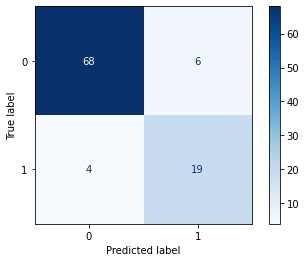

In [101]:
## This matrix visualization is based on 0.5 threshold
plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

In [102]:
print("True Positive: %s" % tp)
print("False Pasitive: %s" % fp)
print("True Negative: %s" % tn)
print("False Negative: %s" % fn)

True Positive: 19
False Pasitive: 6
True Negative: 68
False Negative: 4


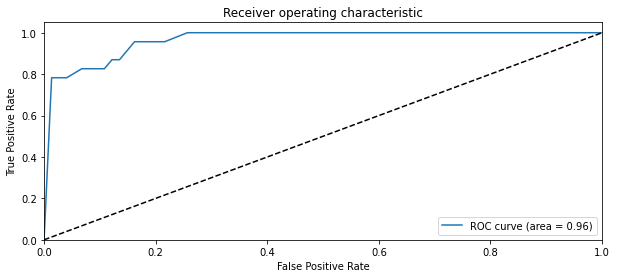

In [103]:
plt.figure(figsize=(10,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (auc_score))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## Dump To Pickle

In [50]:
# clf = model_choice
# clf = clf.fit(X, y)
# pickle.dump(clf, open('../models/final_prediction.pickle', 'wb'))

In [51]:
# feat_imp = pd.Series(clf.get_booster().get_fscore()).sort_values(ascending=False)
# feat_imp.plot(kind='bar', title='Feature Importances')
# plt.ylabel('Feature Importance Score')
# plt.show()